In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn

In [2]:
from glob import glob 
import os
import tqdm as tqdm 

import numpy as np
import scipy.ndimage
import stl

In [3]:
PATHS = {
    'DATA': '../data/RII',
    'DESC': '../data/REPRISEIIISizes.xlsx'
}

In [4]:
def load_mesh(path, meta):
    """
    Created on Mon Dec  4 14:04:02 2017
    @author: srivak1
    """
    
    #import STL file
    mesh = stl.mesh.Mesh.from_file(path)
    #pull data points associated with mesh
    seg = mesh.points
    #Mesh is defined by a number of triangles. Each triangle has three points defined by 3 coordinates.
    #We will average the coordinates of each triangle to form an outer boundary for the mask
    #I've found that the X and Y coordinates for the STL may be flipped relative to the pixel array in dicoms.
    #be sure that they line up appropriately. This is why first coordinate is made up of 1, 4 and 7 instead of 0, 3 and 6
    
    seg = np.array([[(temp[2] + temp[5] + temp[8]) / 3,
                     (temp[1] + temp[4] + temp[7]) / 3,
                     (temp[0] + temp[3] + temp[6]) / 3] 
                    for temp in seg])
    #stl coordinates are the same as actual space on the CT. I am only adjusting to make them relative to the first
    #slice. You will likely have a different way of doing this. Don't worry about first_vx,first_vy, and first_vz being
    #undefined here
    
    seg = np.abs(seg - meta['ImagePosPat']) 

    #initialize mask the same size as patient data (undefined here)
    mask = np.zeros(np.ceil(meta['Shape'] * meta['PixSpac']).astype(np.uint), dtype=np.bool)
    #extract only unique coordinates from segmentation, as there are a lot of repeats from small triangles
    sub_seg = np.unique(np.round(seg), axis=0).astype(int)
    #for each point in the segmentation, set the mask to 1. You may find a better way to do this
    for g in sub_seg:
        mask[g[0], g[1], g[2]] = True
    #segmentation is only the border. To fill in segmentation, use binary_fill_holes    
    mask = scipy.ndimage.binary_fill_holes(mask)
    mask = scipy.ndimage.zoom(mask, 1 / meta['PixSpac'], order=0)
    return mask

In [5]:
# Load the scans in given folder path
def load_scan(patient_id):
    paths = glob(os.path.join(PATHS['DATA'], patient_id, '*.npz'))
    slices = [np.load(path) for path in paths]
    slices = sorted(slices, key=lambda x: x['SliceLoc'])
    return slices

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s['dat'] for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number]['ResInt']
        slope = slices[slice_number]['ResSlo']
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


In [8]:
def load_patient(patient_id, metadata=False):
    slices = load_scan(patient_id)
    out = get_pixels_hu(slices)
    if metadata:
        meta = dict(slices[0])
        meta['SliceThickness'] = (slices[-1]['SliceLoc'] - slices[0]['SliceLoc']) / (len(slices) - 1)
        meta['PixSpac'] = np.array([meta['SliceThickness']] + meta['PixSpac'][::-1].tolist())
        meta['ImagePosPat'] = meta['ImagePosPat'][::-1]
        meta['Shape'] = np.array(out.shape)
        out = [out, meta]
    return out

In [17]:
patient_id = '0201RPII019OMK'
patient, meta = load_patient(patient_id, metadata=True)
meshs = glob(os.path.join(PATHS['DATA'], patient_id, '*.stl'))
meshs = [load_mesh(path, meta) for path in meshs]

/usr/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


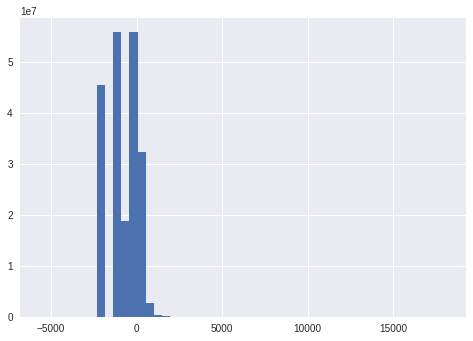

In [14]:
plt.hist(patient[patient != 0], 50);

In [10]:
import SimpleITK as sitk


def segment_nodule(image: sitk.Image, nodule: dict, lower_threshold=-600, upper_threshold=500, maximum_rms_error=0.02,
                   number_of_iterations=1000, curvature_scaling=0.5, radius=3):
    """
    Given an image and a nodule location, this function segments the nodule, using the
    ThresholdSegmentationLevelSetImageFilter from ITK.
    See https://itk.org/Doxygen/html/classitk_1_1SegmentationLevelSetImageFilter.html for further details on the Method
    Args:
      image: sitk.Image: Input Image
      nodule: dict: Nodule coordinates, in the form {"x": 1, "y": 1, "z": 1}
      lower_threshold:  Lower Hu threshold of the nodule to be segmented. Should be about the Hu of lung
                      (Default value = -600)
      upper_threshold: Upper Hu threshold of the nodule to be segmented. Should be less than the Hu of bone
                       (Default value = 500)
      maximum_rms_error: Stopping condition for the iterative solver.
      number_of_iterations: Maximum number of iterations to run
      curvature_scaling: Controls the smoothness of the contour. Higher value - smoother contour
      radius: Sets the radius of the initial segmentation around the nodule.
    Returns:
        mask: filepath to segmentation mask
        diameters: list of diameters
        volumes: list of  volumes
    """

    seed = (nodule["x"], nodule["y"], nodule["z"])
    # Create initial levelset based on the seed and the signed Maurer distance
    seg = sitk.Image(image.GetSize(), sitk.sitkUInt8)
    seg.CopyInformation(image)
    seg[seed] = 1
    # Binary dilate enlarges the seed mask by 3 pixels in all directions.
    seg = sitk.BinaryDilate(seg, radius)
    init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)

    lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
    # Sets the Hu value range for the nodule
    lsFilter.SetLowerThreshold(lower_threshold)
    lsFilter.SetUpperThreshold(upper_threshold)
    # Set stopping conditions
    lsFilter.SetMaximumRMSError(maximum_rms_error)
    lsFilter.SetNumberOfIterations(number_of_iterations)
    # CurvatureScaling controls how smooth the contour will be.
    lsFilter.SetCurvatureScaling(curvature_scaling)
    # PropagationScaling is also known as "balloon-force". Causes the segmented area to grow.
    lsFilter.SetPropagationScaling(1)
    lsFilter.ReverseExpansionDirectionOn()
    ls = lsFilter.Execute(init_ls, sitk.Cast(image, sitk.sitkFloat32))
    # Convert to binary mask
    mask = ls > 0

    # Calculate diameter and volume
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.ComputeFeretDiameterOn()
    stats.SetBackgroundValue(0)
    stats.Execute(mask)
    diameter = stats.GetFeretDiameter(1)
    volume = stats.GetPhysicalSize(1)

    return mask, diameter, volume

In [11]:
def region_growing(img, seed, minthr, maxthr, structure=None, copy=True):
    """code was taken from:
    https://github.com/loli/medpy/wiki/Basic-image-manipulation
    """
    if copy:
        img = img.copy()
    img[seed] = minthr
    thrimg = (img < maxthr) & (img >= minthr)
    lmap, _ = scipy.ndimage.label(thrimg, structure=structure)
    lids = np.unique(lmap[seed])
    region = np.zeros(img.shape, np.bool_)
    for lid in lids:
        region |= lmap == lid
    return region


In [21]:
region = region_growing(patient, (30, 250, 175), 450, 600)
# region = scipy.ndimage.binary_fill_holes(region)
# region = scipy.ndimage.label(scipy.ndimage.binary_opening(region, iterations=2))[0] == 1
region = region_growing(patient, np.where(region), 350, 750)
# region = scipy.ndimage.binary_fill_holes(region)
region = scipy.ndimage.label(scipy.ndimage.binary_opening(region, iterations=2))[0] == 1
region = scipy.ndimage.binary_dilation(region, iterations=7) ^ scipy.ndimage.binary_erosion(region, iterations=7)

# region = region_growing(patient, np.where(region), 350, 750)
# # region = scipy.ndimage.binary_fill_holes(region)
# region = scipy.ndimage.label(scipy.ndimage.binary_opening(region, iterations=2))[0] == 2

In [12]:
def growing_heart(patient, seeds, 
#                   threshold=INITIAL_THRESHOLD, 
#                   step=STEP,
                  full_extraction=True):
    
    
    seeds = seeds.astype(bool_)
    seeds = region_growing(patient.copy(), seeds, -5010, threshold)
    volume = count_nonzero(seeds)
    
    lungs_thresh = filters.threshold_otsu(patient[patient.shape[0] // 2])
    
    ret = None
    while True:    
        labeled = region_growing(patient.copy(), seeds, -5010, threshold + step)
        new_volume = count_nonzero(labeled)
        if new_volume >= volume * 2:
            if step == 4:
                ret = seeds.copy()
                if not full_extraction:
                    return ret
                
            if step == 2:
                return ret, seeds
            step = ceil(step * 0.5)
            continue
        
        threshold += step
        volume = new_volume
        seeds = labeled
        
        if threshold >= lungs_thresh:
            if ret is None:
                ret = seeds.copy()
            
            if not full_extraction:
                return ret
            
    return ret, seeds

In [13]:
BOTTOM = 25
TOP = 100
CPU = 1
FILTERS_AMOUNT = 6

In [14]:
from numpy import *
from scipy.ndimage import morphology 
from tqdm import tqdm
import time
from os.path import join, basename, isfile
from multiprocessing import Pool
from scipy.ndimage import label
import scipy.ndimage.filters as filters
import functools

from scipy.linalg import norm
from scipy.ndimage.filters import gaussian_filter, laplace


def get_scales(bottom=BOTTOM, top=TOP, 
               amount=FILTERS_AMOUNT):
    radius = (top / bottom) ** (1. / (amount - 1))
    sigmas = [bottom / 4.]
    for i in range(amount - 1):
        sigmas.append(sigmas[0] * (radius ** i + 1))
    return sigmas


# In[7]:

def load_data(patient_path, mask_path):    
    ct_scan = read_ct_scan(patient_path)
    mask = load(mask_path)
    patient = get_pixels_hu(ct_scan)
    patient, spacing = resample(patient, ct_scan, SPACING)
    mask, spacing = resample(mask, ct_scan, SPACING)
    
    mask = morphology.binary_fill_holes(
        morphology.binary_dilation(
            morphology.binary_fill_holes(mask > 0), 
            iterations=4)
    )

    return patient, mask


# In[8]:


def hessian(field, coords):
    grad = gradient(field)
    axis = [[0, 1, 2], [1, 2], [2]]
    hess = [gradient(deriv, axis=j) 
            for i, deriv in enumerate(grad) 
            for j in axis[i]]

#   [(0, xx), (1, xy), (2, xz), (3, yy), (4, yz), (5, zz)]
#   x, y, z -> 3, 3, x, y, z -> 3, 3, N

    for j in range(len(hess)):
        hess[j] = hess[j][coords]

    return asarray([[hess[0], hess[1], hess[2]],
                    [hess[1], hess[3], hess[4]],
                    [hess[2], hess[4], hess[5]]])


def enhanced_filter(patient, coords, sigma):
    filtered = gaussian_filter(patient, sigma=sigma)
    hess = hessian(filtered, coords=coords)
    hess = [hess[:, :, i] for i in range(hess.shape[-1])]
    with Pool(CPU) as pool:
        eigs = pool.map(linalg.eigvalsh, 
                        hess)

    sigma_sqr = sigma ** 2
    z_dot = [sigma_sqr * (eig_val[2] ** 2) / abs(eig_val[0]) 
             if eig_val[0] < 0 
             and eig_val[1] < 0 
             and eig_val[2] < 0 
             else 0
             for eig_val in eigs]

    z_line = [sigma_sqr * abs(eig_val[1]) 
              * (abs(eig_val[1]) - abs(eig_val[2])) 
              / abs(eig_val[0]) 
              if eig_val[0] < 0 
              and eig_val[1] < 0 
              else 0
              for eig_val in eigs]
    return z_dot, z_line


def apply_enhs_filters(patient, mask, include_plane=False):
    sigmas = get_scales()
    enh_dot = zeros(mask.shape)
    enh_line = zeros(mask.shape)
    coords = where(mask)
    
    z_dot = list()
    z_line = list()
    for sigma in sigmas:
        dot, line = enhanced_filter(patient, coords, sigma)
        z_dot.append(dot)
        z_line.append(line)


    enh_dot[coords] = asarray(z_dot).max(axis=0)
    enh_line[coords] = asarray(z_line).max(axis=0)

    return enh_dot, enh_line

# In[9]:

def divergence(sigma, patient):
    grad = asarray(gradient(patient))
    grad /= norm(grad, axis=0) + 1e-3
    grad = [gaussian_filter(deriv, sigma=sigma) for deriv in grad]
    return sum([gradient(el, axis=i) 
                for i, el in enumerate(grad)], axis=0)


# In[10]:

def apply_divergence(masks_pats):
    divs_list = []
    for mask,pat,_ in tqdm(masks_pats):
        with Pool(CPU) as pool:
            _divs = pool.map(functools.partial(divergence, 
                                               patient=pat), sigmas)
        _divs = -1 * asarray(_divs) * mask 
        _divs = _divs.max(axis=0)
        divs_list.append(_divs.copy())
    return divs_list


# isolated nodules

# In[11]:

def is_in(colour, labe, dng_colours):
    if colour in dng_colours:
        return labe == colour



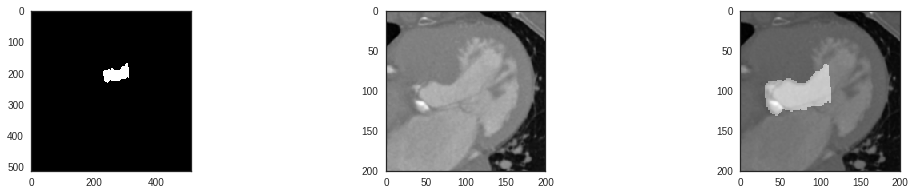

In [72]:
i = 220
plt.figure(figsize=(14, 10))
plt.subplot(331)
plt.imshow(~meshs[1][i])
plt.subplot(332)
plt.imshow(-(patient[i])[100:300, 200:400])
plt.subplot(333)
plt.imshow(-(patient[i] + 1000 * meshs[1][i, :512, :512])[100:300, 200:400])

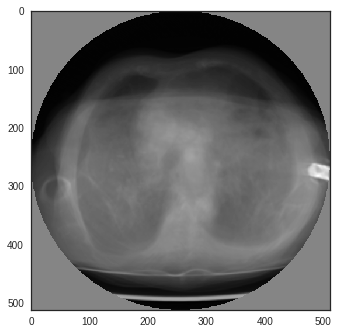

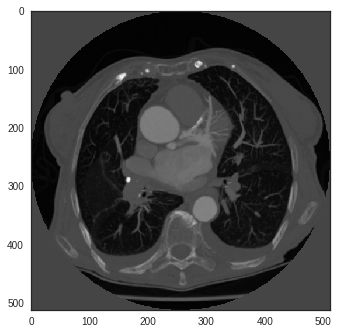

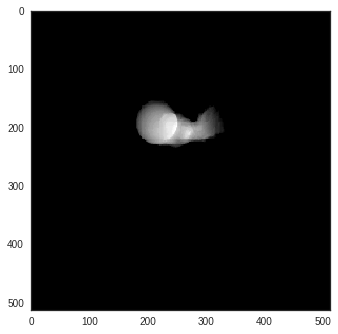

In [59]:
plt.gray()
tmp = patient.copy()
# tmp[(tmp < 350) | (tmp >= 700)] = 0 
plt.imshow(tmp.mean(0))
plt.show()

plt.imshow(tmp[180:188].max(0))
plt.show()

plt.imshow(meshs[1].mean(0))
plt.show()
seaborn.set_style('white')

In [15]:
from tqdm import tqdm

/usr/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


Slice


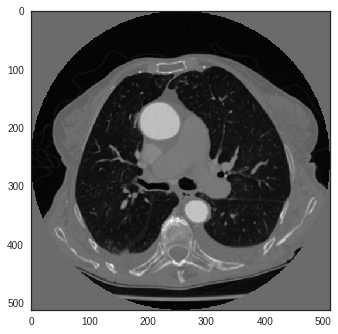

Internal Marker


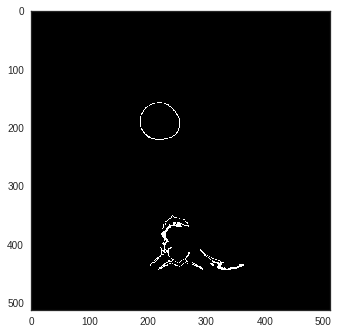

External Marker


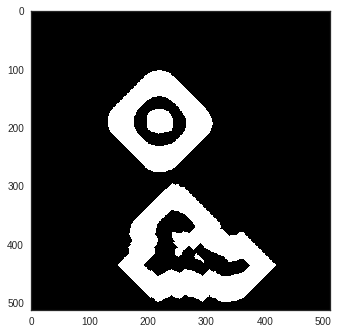

Watershed Marker


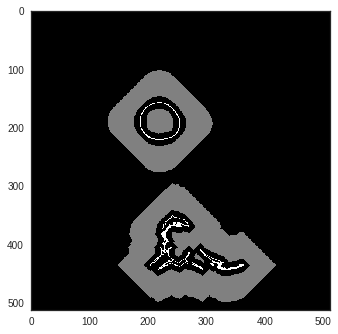

In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Some of the starting Code is taken from ArnavJain, since it's more readable then my own
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = (image >= 350) & (image < 700)
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-4]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed
#Show some example markers from the middle        
i = 145
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(patient[i])
print ("Slice")
plt.imshow(patient[i], cmap='gray')
plt.show()
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

In [15]:
import pandas as pd
from glob import glob

glob('../data/RII/0201RPII0/*')
df = pd.read_excel('../data/REPRISEIIISizes.xlsx')
df['Valve Size (Model number)'].value_counts()

27 mm    236
25 mm    236
23 mm    206
Name: Valve Size (Model number), dtype: int64

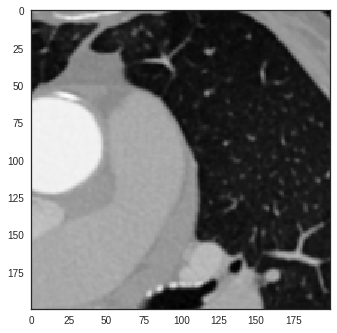

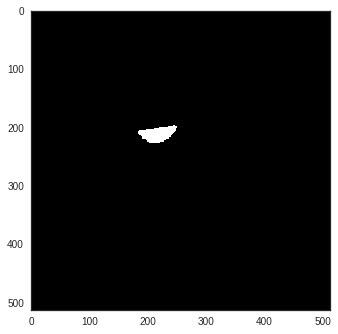

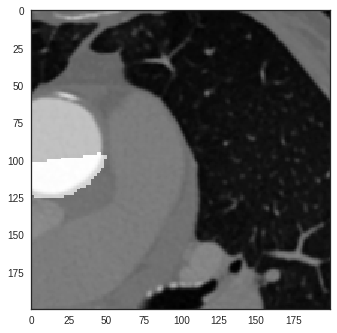

In [88]:
i = 159
plt.imshow(-patient[i][100: 300, 200: 400])
plt.show()
plt.imshow(~meshs[1][i])
plt.show()
plt.imshow(-(patient[i] + 1000 * meshs[1][i][:512, :512])[100: 300, 200: 400])
plt.show()

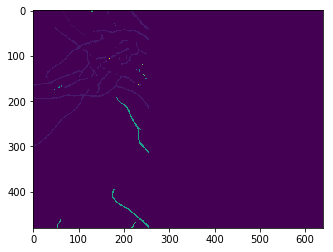

In [27]:
plt.imshow(scipy.ndimage.label(a)[0][34])

In [47]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000 * np.ones((512, 512)))
#     segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, 
    return segmented, marker_watershed

#Some Testcode:
# test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, \
#     test_marker_internal, test_marker_external, test_marker_watershed
croped = []
segmented = []
for i in tqdm(range(len(patient))):
    s, w = seperate_lungs(patient[i])
    croped.append(s)
    segmented.append(w)

croped = np.array(croped)
segmented = np.array(segmented)

print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.show()

 16%|█▌        | 130/807 [23:25<2:03:03, 10.91s/it]

KeyboardInterrupt: 

In [48]:
croped = np.array(croped)
segmented = np.array(segmented)

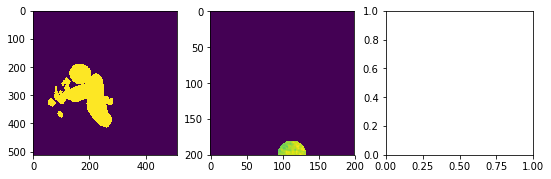

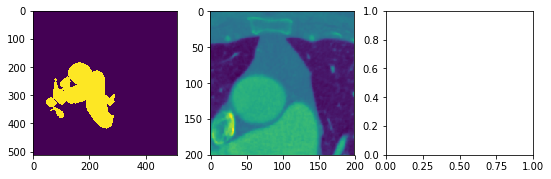

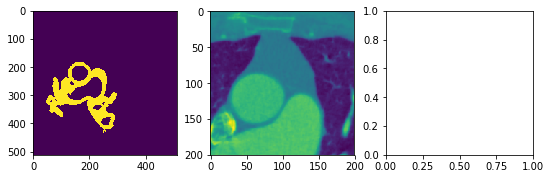

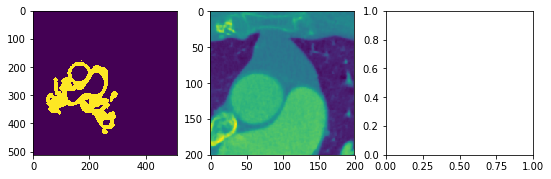

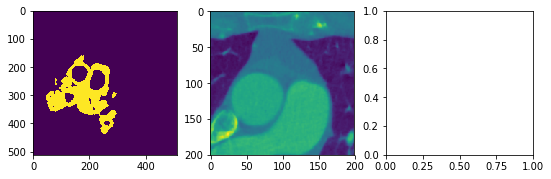

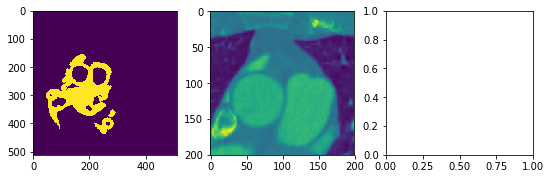

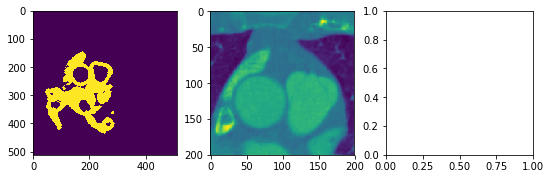

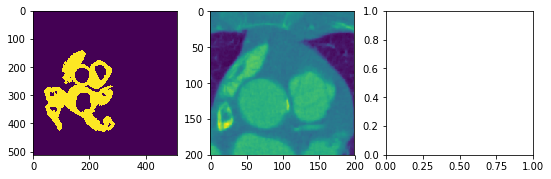

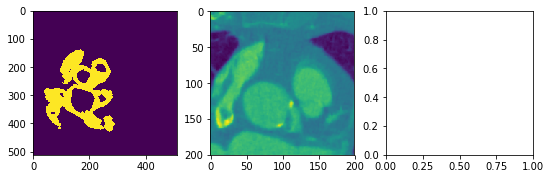

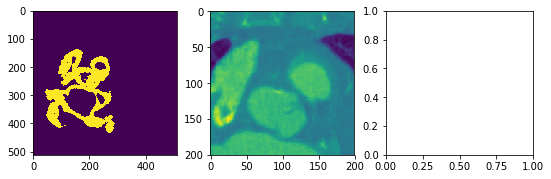

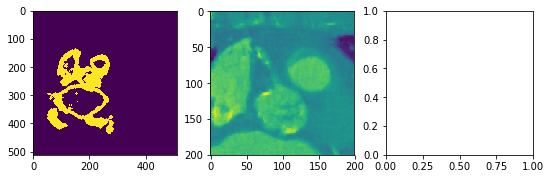

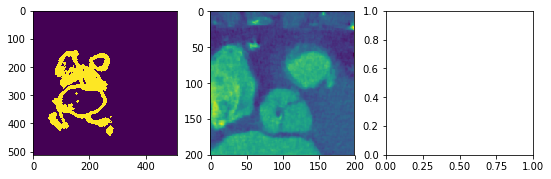

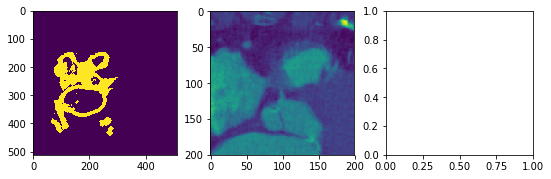

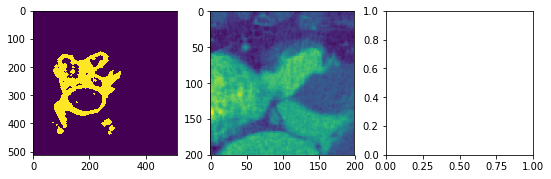

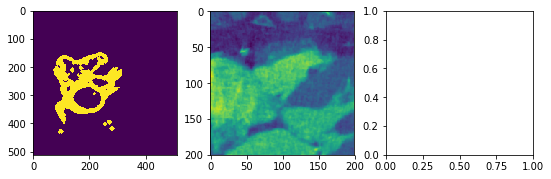

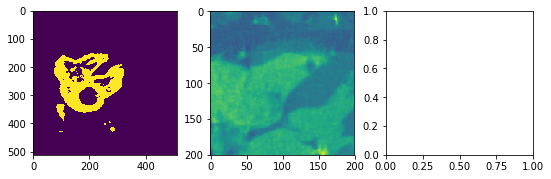

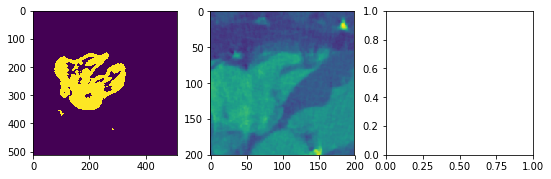

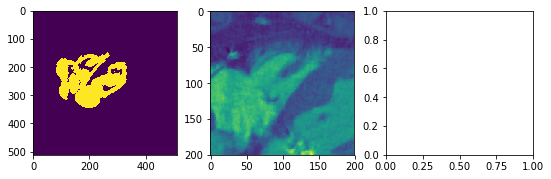

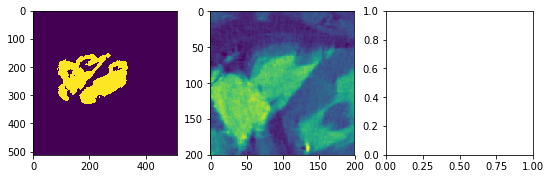

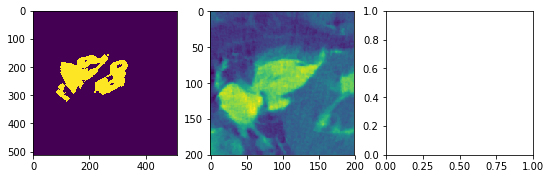

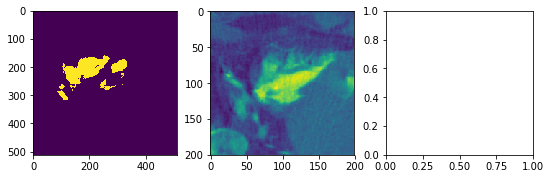

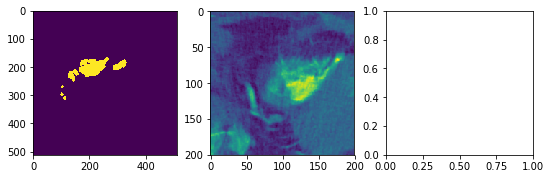

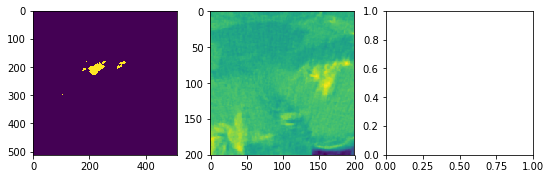

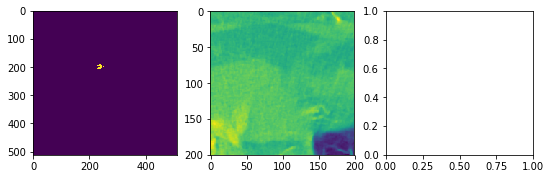

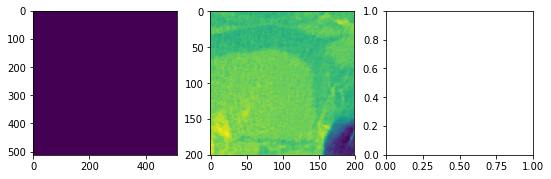

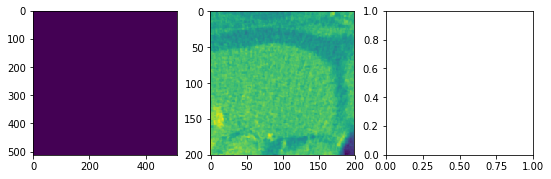

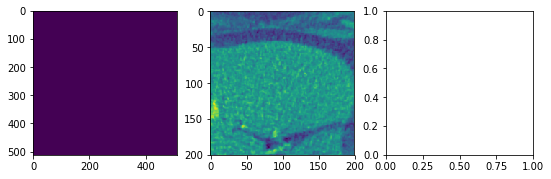

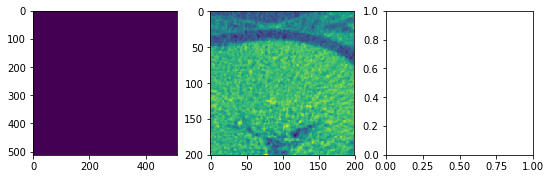

In [38]:
for i in range(0, len(patient), 5):
    plt.figure(figsize=(9, 9))
    plt.subplot(331)
    plt.imshow(region[i])
    plt.subplot(332)
    plt.imshow((patient[i] + 0 * region[i])[100:300, 100:300])
    plt.subplot(333)
#     plt.imshow((patient[i] + 700 * meshs[1][i][:512, :512])[100:300, 100:300])
    plt.show()

In [ ]:
import SimpleITK as sitk

image = sitk.GetImageFromArray(patient)

# seed = (30, 250, 175)
lower_threshold=380
upper_threshold=750
maximum_rms_error=12
number_of_iterations=10
curvature_scaling=5
radius=3

# Create initial levelset based on the seed and the signed Maurer distance
seg = sitk.GetImageFromArray(region.astype(np.uint8))
# Binary dilate enlarges the seed mask by 3 pixels in all directions.
# seg = sitk.BinaryDilate(seg, radius)
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)

lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
# Sets the Hu value range for the nodule
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
# Set stopping conditions
lsFilter.SetMaximumRMSError(maximum_rms_error)
lsFilter.SetNumberOfIterations(number_of_iterations)
# CurvatureScaling controls how smooth the contour will be.
lsFilter.SetCurvatureScaling(curvature_scaling)
# PropagationScaling is also known as "balloon-force". Causes the segmented area to grow.
lsFilter.SetPropagationScaling(1)
lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(image, sitk.sitkFloat32))
# Convert to binary mask
mask = ls > 0

# Calculate diameter and volume
stats = sitk.LabelShapeStatisticsImageFilter()
stats.ComputeFeretDiameterOn()
stats.SetBackgroundValue(0)
stats.Execute(mask)
diameter = stats.GetFeretDiameter(1)
volume = stats.GetPhysicalSize(1)

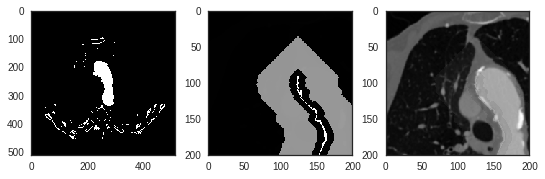

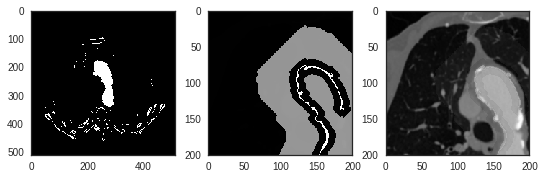

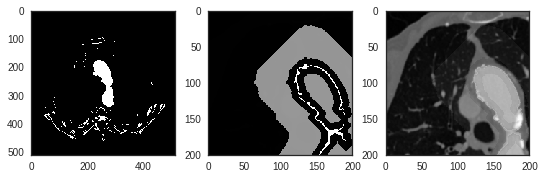

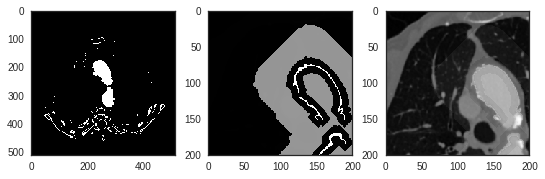

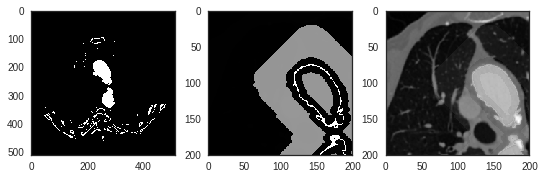

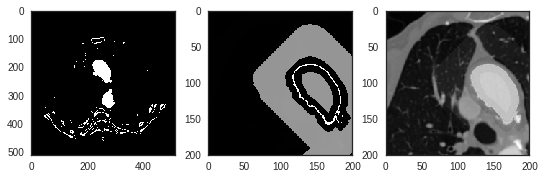

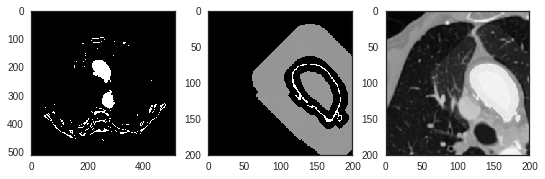

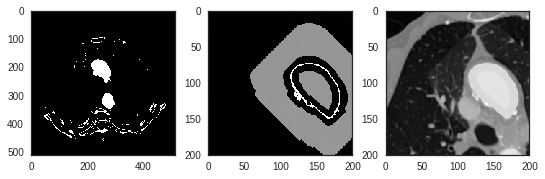

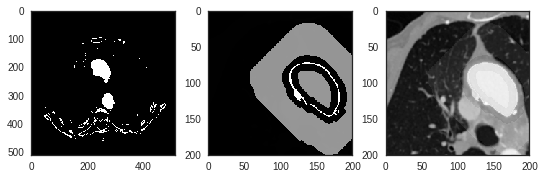

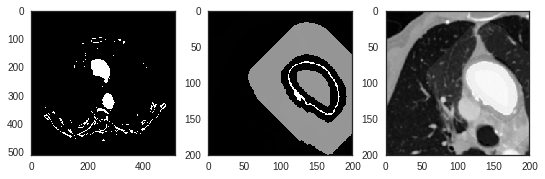

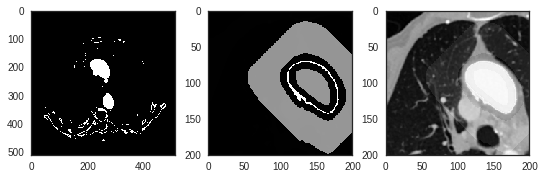

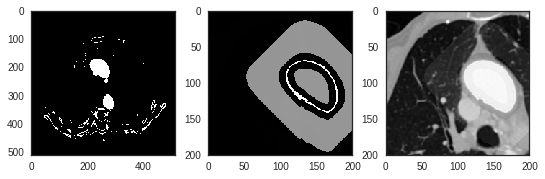

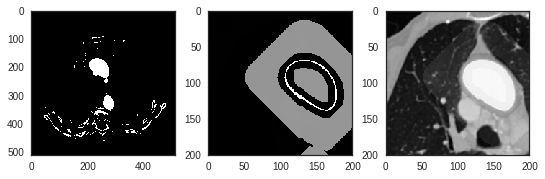

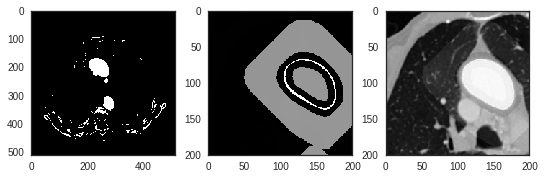

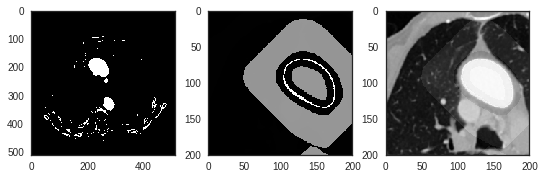

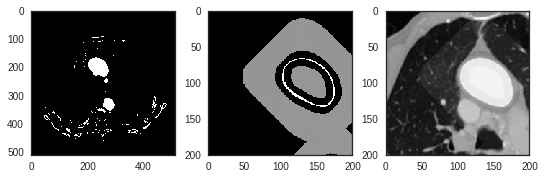

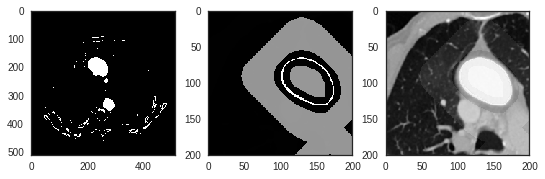

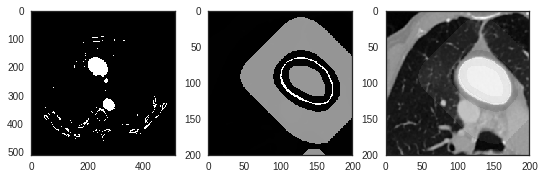

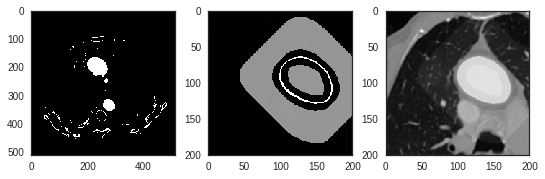

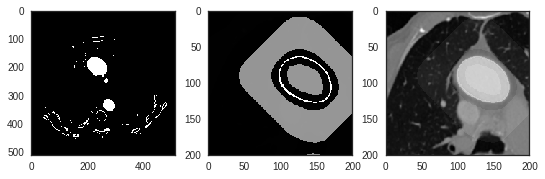

In [58]:
for i in range(110, len(segmented), 1):
    plt.figure(figsize=(9, 9))
    plt.subplot(331)
    plt.imshow(~(patient[i] > 400) & (patient[70] < 750))
    plt.subplot(332)
    plt.imshow(-(patient[i] + 700 * segmented[i])[100:300, 100:300])
    plt.subplot(333)
    plt.imshow(-(patient[i] + segmented[i][:512, :512])[100:300, 100:300])
    plt.show()

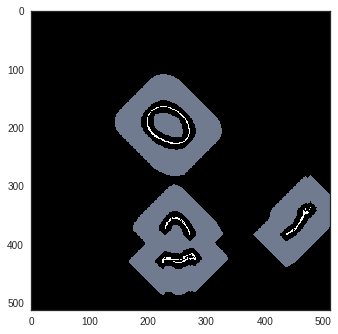

In [49]:
# patient = (patient > 350) & (patient < 500) #blood

import matplotlib.animation as animation

def animate(volume, gifname):
    # Based on @Zombie's code
    fig = plt.figure()
    anim = plt.imshow(volume[0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(volume[i])
        return anim,
    
    a = animation.FuncAnimation(fig, update, frames=range(len(volume)), interval=50, blit=True)
    a.save(gifname, writer='imagemagick')
    
    
animate(segmented, 'mesh_applied.gif')

In [20]:
meshs

False

In [29]:
slices

array([ 57439, 156736, 169075])

In [35]:
zxy

array([ 193.,  135.,  186.])

In [65]:
# patient_id = '0201RPII019OMK'
# patient, meta = load_patient(patient_id, metadata=True)
# meshs = glob(os.path.join(PATHS['DATA'], patient_id, '*.stl'))
# meshs = [load_mesh(path, meta) for path in meshs]
# meshs = scipy.ndimage.label(meshs[1])[0] == 1
zss = np.array(np.where(meshs)).T

n = 7
cell_size = 100

cell = np.zeros(shape=(2, cell_size, cell_size))
maze = np.zeros(shape=(2, cell_size * n, cell_size * n))

frequency = 3 # one out of `frequency` will be positive
slices = np.random.choice(zss[:, 0], size=n ** 2)

zxy = np.zeros(shape=(3,), dtype=np.int16)

for i, zslice in enumerate(slices):
    if not np.random.randint(frequency):
        zxy = zss[zss[:, 0] == zslice]
        zxy = zxy[np.random.choice(len(zxy))]
    else:
        zxy[0] = zslice
        zxy[1:] = np.random.choice(patient.shape[-1], size=2)
        
    zxy[1:] = np.clip(zxy[1:] - cell_size // 2, 0, patient.shape[-1] - cell_size)
    cell[0] = patient[
        zxy[0], 
        zxy[1]: zxy[1] + cell_size, 
        zxy[2]: zxy[2] + cell_size
    ]
    cell[1] = mask[
        zxy[0], 
        zxy[1]: zxy[1] + cell_size, 
        zxy[2]: zxy[2] + cell_size
    ]
    if np.random.randint(2):
        np.flip(cell, axis=1)
    if np.random.randint(2):
        np.flip(cell, axis=2)
    maze[
        :,
        (i // n) * cell_size: (i // n + 1) * cell_size, 
        (i % n) * cell_size: (i % n + 1) * cell_size
    ] = cell.copy()
    

# for i in 

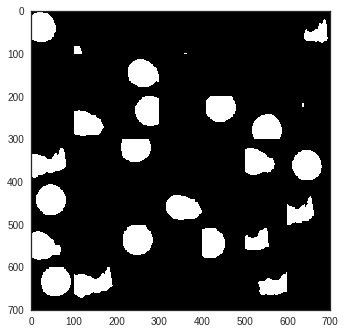

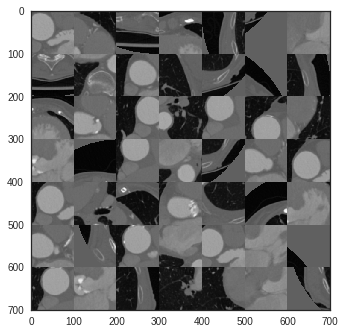

In [66]:
seaborn.set_style('white')
plt.imshow(-maze[1])
plt.show()
plt.imshow(-maze[0])
plt.show()

In [59]:
from PIL import Image, ImageDraw
from PIL import ImageFont
import matplotlib.pyplot as plt
%matplotlib inline

image = pickle.loads(open('0bd0e3056cbf23a1cb7f0f0b18446068.pkl','rb').read())

def set_color(mu):
    c = int((550 + mu)/100*255)
    return (c,0,c)

im = Image.new('RGBA', (int(image.shape[1] + image.shape[0]/10), int(image.shape[2] + image.shape[0]/10)))
d = ImageDraw.Draw(im)
for z in range(0,image.shape[0], 10):
    for x in range(image.shape[2]-10):
        for y in range(image.shape[1]-10):
            mu = image[z][y][x] -1024
            if -550<mu and mu<-450: #lung
                im.putpixel((int(x+z/10), int(y+z/10)), set_color(mu))
                #fill surrounding
                for o1 in range(1,10):
                    for o2 in range(1,10):
                        mu2 = image[z][y+o1][x+o2] -1024
                        if -100<mu2 and mu2<-50: #fat
                            im.putpixel((int(x+o1+z/10), int(y+o2+z/10)), (255,182,193))
                        if 30<mu2 and mu2<45: #blood
                            im.putpixel((int(x+o1+z/10), int(y+o2+z/10)), (255,0,0))
                        if -1010<mu2 and mu2<-990: #air
                            im.putpixel((int(x+o1+z/10), int(y+o2+z/10)), (135,206,235))
            if mu>500: #bone
                im.putpixel((int(x+z/10), int(y+z/10)), (35,35,35))
plt.imshow(im); plt.axis('off')

NameError: name 'pickle' is not defined